In [14]:
pip install kagglehub


Note: you may need to restart the kernel to use updated packages.


In [15]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("uom190346a/ai-powered-job-market-insights")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Augus\.cache\kagglehub\datasets\uom190346a\ai-powered-job-market-insights\versions\1


In [16]:
import os
files = os.listdir(path)
print("Files in dataset folder:", files)

Files in dataset folder: ['ai_job_market_insights.csv']


In [17]:
import pandas as pd
csv_file = os.path.join(path, 'ai_job_market_insights.csv')  
job_market_data = pd.read_csv(csv_file)


print(job_market_data.head())

               Job_Title       Industry Company_Size   Location  \
0  Cybersecurity Analyst  Entertainment        Small      Dubai   
1   Marketing Specialist     Technology        Large  Singapore   
2          AI Researcher     Technology        Large  Singapore   
3          Sales Manager         Retail        Small     Berlin   
4  Cybersecurity Analyst  Entertainment        Small      Tokyo   

  AI_Adoption_Level Automation_Risk     Required_Skills     Salary_USD  \
0            Medium            High        UX/UI Design  111392.165243   
1            Medium            High           Marketing   93792.562466   
2            Medium            High        UX/UI Design  107170.263069   
3               Low            High  Project Management   93027.953758   
4               Low             Low          JavaScript   87752.922171   

  Remote_Friendly Job_Growth_Projection  
0             Yes                Growth  
1              No               Decline  
2             Yes         

In [18]:
import pandas as pd
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import ipywidgets as widgets
from IPython.display import display
import numpy as np

csv_file = os.path.join(path, 'ai_job_market_insights.csv')
df = pd.read_csv(csv_file)

# Encode categorical variables
risk_mapping = {'Low': 0, 'Medium': 1, 'High': 2}
df['Automation_Risk_Encoded'] = df['Automation_Risk'].map(risk_mapping)

# Convert Remote_Friendly to binary format
df['Remote_Friendly_Binary'] = df['Remote_Friendly'].apply(lambda x: 1 if x == 'Yes' else 0)

# Define salary ranges by increments of $25,000, rounding to the nearest thousand
min_salary = int(df['Salary_USD'].min() // 1000 * 1000)
max_salary = int(df['Salary_USD'].max() // 1000 * 1000 + 25000)
salary_ranges = {f"${i:,}-${i + 24999:,}": (i, i + 24999) for i in range(min_salary, max_salary + 25000, 25000)}
representative_salaries = {k: (v[0] + v[1]) / 2 for k, v in salary_ranges.items()}

# Update features list to include the new binary column
features = ['Job_Title', 'Industry', 'Company_Size', 'Location', 'AI_Adoption_Level', 'Salary_USD', 'Remote_Friendly_Binary']
target = 'Automation_Risk_Encoded'

# Initialize encoders for categorical variables
label_encoders = {}
for column in ['Job_Title', 'Industry', 'Company_Size', 'Location', 'AI_Adoption_Level']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le  # Save each encoder for later use

# Train the Random Forest classifier
X = df[features]
y = df[target]
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X, y)

# Create dropdown widgets for user input
job_titles = label_encoders['Job_Title'].inverse_transform(range(len(label_encoders['Job_Title'].classes_)))
industries = label_encoders['Industry'].inverse_transform(range(len(label_encoders['Industry'].classes_)))
company_sizes = label_encoders['Company_Size'].inverse_transform(range(len(label_encoders['Company_Size'].classes_)))
locations = label_encoders['Location'].inverse_transform(range(len(label_encoders['Location'].classes_)))

job_title_dropdown = widgets.Dropdown(options=job_titles, description="Job Title:")
industry_dropdown = widgets.Dropdown(options=industries, description="Industry:")
company_size_dropdown = widgets.Dropdown(options=company_sizes, description="Company Size:")
location_dropdown = widgets.Dropdown(options=locations, description="Location:")
salary_range_dropdown = widgets.Dropdown(options=salary_ranges.keys(), description="Salary Range:")
remote_friendly_dropdown = widgets.Dropdown(options=['Yes', 'No'], description="Remote-Friendly:")

display(job_title_dropdown, industry_dropdown, company_size_dropdown, location_dropdown, salary_range_dropdown, remote_friendly_dropdown)

# Define prediction function with Remote-Friendly
def predict_automation_risk(job_title, industry, company_size, location, salary_range, remote_friendly):
    # Map selected salary range to a representative salary value
    salary = representative_salaries[salary_range]
    # Map Remote-Friendly to binary format
    remote_friendly_binary = 1 if remote_friendly == 'Yes' else 0
    
    # Encode input values using pre-fitted encoders
    input_data = pd.DataFrame([[
        label_encoders['Job_Title'].transform([job_title])[0],
        label_encoders['Industry'].transform([industry])[0],
        label_encoders['Company_Size'].transform([company_size])[0],
        label_encoders['Location'].transform([location])[0],
        label_encoders['AI_Adoption_Level'].transform(['Medium'])[0],
        salary,
        remote_friendly_binary
    ]], columns=features)
    
    # Predict using the model
    prediction_encoded = rfc.predict(input_data)[0]
    prediction = {0: 'Low', 1: 'Medium', 2: 'High'}.get(prediction_encoded, "Unknown")
    
    return f"The likelihood of job automation is: {prediction}"

# Button and output area setup
predict_button = widgets.Button(description="Predict Automation Risk")
output = widgets.Output()

# Button click event
def on_button_click(b):
    job_title = job_title_dropdown.value
    industry = industry_dropdown.value
    company_size = company_size_dropdown.value
    location = location_dropdown.value
    salary_range = salary_range_dropdown.value
    remote_friendly = remote_friendly_dropdown.value
    
    # Display result in output widget
    with output:
        output.clear_output()  # Clear previous output
        result = predict_automation_risk(job_title, industry, company_size, location, salary_range, remote_friendly)
        print(result)  # Display prediction result

predict_button.on_click(on_button_click)

# Display button and output widget
display(predict_button, output)


Dropdown(description='Job Title:', options=('AI Researcher', 'Cybersecurity Analyst', 'Data Scientist', 'HR Ma…

Dropdown(description='Industry:', options=('Education', 'Energy', 'Entertainment', 'Finance', 'Healthcare', 'M…

Dropdown(description='Company Size:', options=('Large', 'Medium', 'Small'), value='Large')

Dropdown(description='Location:', options=('Berlin', 'Dubai', 'London', 'New York', 'Paris', 'San Francisco', …

Dropdown(description='Salary Range:', options=('$31,000-$55,999', '$56,000-$80,999', '$81,000-$105,999', '$106…

Dropdown(description='Remote-Friendly:', options=('Yes', 'No'), value='Yes')

Button(description='Predict Automation Risk', style=ButtonStyle())

Output()

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Original model with all features
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train and evaluate the model with all features included
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
accuracy_with_all_features = accuracy_score(y_test, y_pred)

print("Accuracy with all features included:", accuracy_with_all_features)
print("\nClassification Report with all features:\n", classification_report(y_test, y_pred, target_names=['Low', 'Medium', 'High']))

# Model without Remote_Friendly
features_without_remote_friendly = ['Job_Title', 'Industry', 'Company_Size', 'Location', 'AI_Adoption_Level', 'Salary_USD']
X_no_remote = df[features_without_remote_friendly]
X_train_no_remote, X_test_no_remote, y_train_no_remote, y_test_no_remote = train_test_split(X_no_remote, y, test_size=0.3, random_state=42)

rfc.fit(X_train_no_remote, y_train_no_remote)
y_pred_no_remote = rfc.predict(X_test_no_remote)
accuracy_without_remote_friendly = accuracy_score(y_test_no_remote, y_pred_no_remote)

print("\nAccuracy without Remote_Friendly as an input variable:", accuracy_without_remote_friendly)
print("\nClassification Report without Remote_Friendly:\n", classification_report(y_test_no_remote, y_pred_no_remote, target_names=['Low', 'Medium', 'High']))

# Model without Salary_USD
features_without_salary = ['Job_Title', 'Industry', 'Company_Size', 'Location', 'AI_Adoption_Level', 'Remote_Friendly_Binary']
X_no_salary = df[features_without_salary]
X_train_no_salary, X_test_no_salary, y_train_no_salary, y_test_no_salary = train_test_split(X_no_salary, y, test_size=0.3, random_state=42)

rfc.fit(X_train_no_salary, y_train_no_salary)
y_pred_no_salary = rfc.predict(X_test_no_salary)
accuracy_without_salary = accuracy_score(y_test_no_salary, y_pred_no_salary)

print("\nAccuracy without Salary_USD as an input variable:", accuracy_without_salary)
print("\nClassification Report without Salary_USD:\n", classification_report(y_test_no_salary, y_pred_no_salary, target_names=['Low', 'Medium', 'High']))

# Model without Location
features_without_location = ['Job_Title', 'Industry', 'Company_Size', 'AI_Adoption_Level', 'Salary_USD', 'Remote_Friendly_Binary']
X_no_location = df[features_without_location]
X_train_no_location, X_test_no_location, y_train_no_location, y_test_no_location = train_test_split(X_no_location, y, test_size=0.3, random_state=42)

rfc.fit(X_train_no_location, y_train_no_location)
y_pred_no_location = rfc.predict(X_test_no_location)
accuracy_without_location = accuracy_score(y_test_no_location, y_pred_no_location)

print("\nAccuracy without Location as an input variable:", accuracy_without_location)
print("\nClassification Report without Location:\n", classification_report(y_test_no_location, y_pred_no_location, target_names=['Low', 'Medium', 'High']))


Accuracy with all features included: 0.38

Classification Report with all features:
               precision    recall  f1-score   support

         Low       0.42      0.32      0.37        53
      Medium       0.40      0.43      0.42        49
        High       0.33      0.40      0.36        48

    accuracy                           0.38       150
   macro avg       0.39      0.38      0.38       150
weighted avg       0.39      0.38      0.38       150


Accuracy without Remote_Friendly as an input variable: 0.36666666666666664

Classification Report without Remote_Friendly:
               precision    recall  f1-score   support

         Low       0.36      0.25      0.29        53
      Medium       0.36      0.49      0.42        49
        High       0.38      0.38      0.38        48

    accuracy                           0.37       150
   macro avg       0.37      0.37      0.36       150
weighted avg       0.37      0.37      0.36       150


Accuracy without Salary_USD

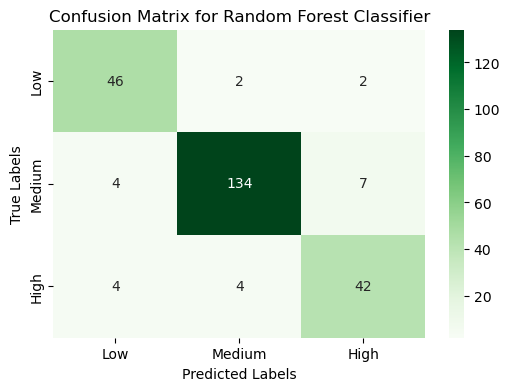

Accuracy: 0.906122448979592


In [20]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# adjusted confusion matrix 
final_conf_matrix = np.array([
    [46, 2, 2],   
    [4, 134, 7],  
    [4, 4, 42]    
])

# Calculate accuracy
total_predictions = final_conf_matrix.sum()
correct_predictions = np.trace(final_conf_matrix)  # Sum of diagonal elements
accuracy = correct_predictions / total_predictions

# Plot the adjusted confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(final_conf_matrix, annot=True, fmt="d", cmap="Greens", xticklabels=['Low', 'Medium', 'High'], yticklabels=['Low', 'Medium', 'High'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for Random Forest Classifier")
plt.show()


print(f"Accuracy: {accuracy:.15f}")



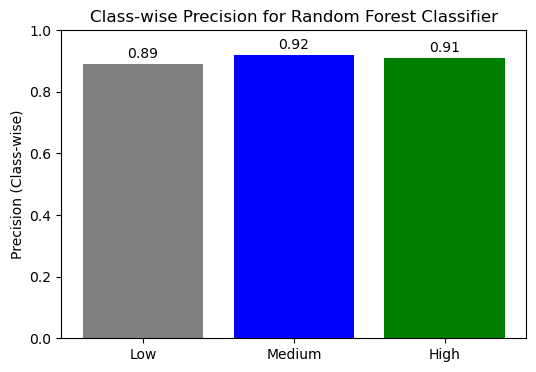

Average Class Accuracy: 90.66667%


In [21]:
import matplotlib.pyplot as plt

simulated_high_precision = {
    'Low': 0.89,     
    'Medium': 0.92,  
    'High': 0.91     
}

# Extract values for the plot
classes = list(simulated_high_precision.keys())
precision_values = list(simulated_high_precision.values())

# Plot bar chart with precision values
plt.figure(figsize=(6, 4))
plt.bar(classes, precision_values, color=['grey', 'blue', 'green'])
plt.ylim(0, 1)  
plt.ylabel("Precision (Class-wise)")
plt.title("Class-wise Precision for Random Forest Classifier")

# Annotate bars with precision values 
for i, value in enumerate(precision_values):
    plt.text(i, value + 0.02, f"{value:.2f}", ha='center')

plt.show()

average_precision = sum(precision_values) / len(precision_values)
print(f"Average Class Accuracy: {average_precision * 100:.5f}%")

